In [4]:
import matplotlib.pyplot as plt
import numpy as np
import serial
import serial.tools.list_ports
import time
from collections import deque
from IPython.display import display, clear_output
from scipy.interpolate import interp1d
import time
from datetime import datetime

import pandas as pd
import os
import struct

vmax = 5


# procedure
# read 3 component directly under power line as fast as posible. do fft to get magnitude at 60hz, and harmonics maybe, and also the offset
# need a way for user to specifly single phase or 3 phase because if 3 phase the signal might be 60*3 hz???

# once we have a magnitude at this r. we can move sensor away from the line and repeat
# this should with measured gps points where these where done should be able to give use I and h(height) becasue we have done with 2 r. 

# then set it to single sensor mode, 
# make code for it to determine the sensir with the best signal (best alligned with power lines) by measuing on all 3 then just go to the best one for faster sampling 
# leave sensor directly under for duration of survey in single sensor mod

# keeping data in integer form until absolutely needed is best 

# radio will be for syncronizing with resot of survey on arduino mega (just will have gps + radio) to keep track of time
# periodically the pico might need to send a packet FFt results, and say what winow it came from
# before that it will send signal saying when it will send a packet so the main data aquistion knows no reference for that time period

KeyboardInterrupt: 

# Live Reading

In [ ]:


# List available ports and print them for user reference
ports = list(serial.tools.list_ports.comports())
print("Available ports:")
for port in ports:
    print(port.device)

Available ports:
COM5


In [ ]:
# Set up the serial connection (update the port as needed)
serial_port = "COM5" 
baud_rate = 115200
window_size = 2048  # Number of samples to show on the plot
refresh_rate = 2048  # Update plot every 10 samples

In [ ]:
# Initialize data buffers
B_data = deque([0] * window_size, maxlen=window_size)
time_data = deque([0] * window_size, maxlen=window_size)

# Initialize plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot for time-domain signal
line1, = ax1.plot(time_data, B_data)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage (V)")
#ax1.set_ylim(-0.5, 0.5)
ax1.grid(True) 

# Plot for FFT power spectrum
fft_line, = ax2.plot([], [], label="FFT Spectrum")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1, 500)  # Placeholder limits
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Power")
ax2.axvline(60, color='red', linestyle='--', linewidth=1, label="60 Hz")
ax2.axvline(180, color='red', linestyle='--', linewidth=1, label="60 Hz")
ax2.grid(True)
plt.ion()  # Enable interactive mode

def try_connect(serial_port, baud_rate):
    """Try to connect to the serial port."""
    while True:
        try:
            ser = serial.Serial(serial_port, baud_rate, timeout=1)
            print(f"Reconnected to {serial_port}")
            return ser
        except (serial.SerialException, OSError):
            print(f"Waiting for device on {serial_port}...")
            time.sleep(1)

try:
    ser = try_connect(serial_port, baud_rate)
    sample_count = 0

    while True:
        try:
            if ser.in_waiting:
                data_chunk = ser.read(ser.in_waiting).decode('utf-8')
                lines = data_chunk.splitlines()

                for line in lines:
                    # Parse voltage and time from the serial input
                    try:
                        voltage, timestamp_us = line.split(",")
                        voltage = float(voltage) / (2**23) * vmax  # Convert raw data to voltage
                        timestamp_s = float(timestamp_us) * 1e-6  # Convert microseconds to seconds
                        B_data.append(voltage)
                        time_data.append(timestamp_s)
                        sample_count += 1

                        # Update the plots every `refresh_rate` samples
                        if sample_count % refresh_rate == 0:
                            # Update time-domain plot
                            line1.set_ydata(list(B_data))
                            line1.set_xdata(list(time_data))

                            times = np.array(time_data)
                            voltages = np.array(B_data)

                            # Interpolate data for uniform sampling
                            interp_times = np.linspace(times[0], times[-1], len(times))
                            interp_voltages = interp1d(times, voltages, kind='linear')(interp_times)

                            # Calculate FFT
                            fft_values = np.fft.rfft(interp_voltages)
                            power_spectrum = np.abs(fft_values)**2
                            power_spectrum[power_spectrum == 0] = 1e-12  # Replace zeros for log scale
                            freqs = np.fft.rfftfreq(len(interp_times), d=(interp_times[1] - interp_times[0]))

                            # Update frequency-domain plot
                            fft_line.set_data(freqs, power_spectrum)
                            ax2.set_xlim(freqs[1], freqs.max())
                            ax2.set_ylim(1e-6, power_spectrum.max() * 1.1)

                            # Rescale and re-display the plots
                            ax1.relim()
                            ax1.autoscale_view()
                            ax2.relim()
                            ax2.autoscale_view()
                            clear_output(wait=True)
                            display(fig)

                    except (ValueError, IndexError):
                        # Skip lines that cannot be parsed
                        pass

        except (serial.SerialException, OSError):
            print("Device disconnected. Waiting for reconnection...")
            ser.close()
            ser = try_connect(serial_port, baud_rate)

except KeyboardInterrupt:
    print("Plotting stopped by user.")
finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()


Reconnected to COM5
Plotting stopped by user.
Error in callback <function _draw_all_if_interactive at 0x00000247307CBDC0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x800 with 2 Axes>

In [ ]:
# Generate filename based on the current time
start_time = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"data_{start_time}.txt"

def try_connect(serial_port, baud_rate):
    """Try to connect to the serial port."""
    while True:
        try:
            ser = serial.Serial(serial_port, baud_rate, timeout=1)
            print(f"Reconnected to {serial_port}")
            return ser
        except (serial.SerialException, OSError):
            print(f"Waiting for device on {serial_port}...")
            time.sleep(1)

try:
    ser = try_connect(serial_port, baud_rate)
    with open(file_name, 'w') as file:  # Open the file in write mode
        print(f"Saving data to {file_name}...")
        
        while True:
            try:
                if ser.in_waiting:
                    data_chunk = ser.read(ser.in_waiting).decode('utf-8')
                    lines = data_chunk.splitlines()

                    for line in lines:
                        # Write non-empty lines to the file
                        if line.strip():  # Check if the line is not empty after removing whitespace
                            file.write(line + '\n')
                            file.flush()  # Ensure the data is written immediately

            except (serial.SerialException, OSError):
                print("Device disconnected. Waiting for reconnection...")
                ser.close()
                ser = try_connect(serial_port, baud_rate)

except KeyboardInterrupt:
    print("Data saving stopped by user.")
finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()


: 

: 

: 

: 

In [ ]:
voltages = []
times = []
try:
    with open(file_name, 'r') as file:
        for line in file:
            if line.strip():  # Skip empty lines
                data, timestamp = map(int, line.split(','))
                voltage = (data / (2**23)) * vmax
                time_sec = timestamp / 1e6
                voltages.append(voltage)
                times.append(time_sec)
except FileNotFoundError:
    print(f"File {file_name} not found. Ensure the file exists and the name is correct.")
    exit()

# Interpolate data for uniform sampling
interp_times = np.linspace(times[0], times[-1], len(times))
interp_voltages = interp1d(times, voltages, kind='linear')(interp_times)

# Calculate average sampling frequency
time_intervals = np.diff(times)
average_sampling_frequency = 1 / np.mean(time_intervals)
print(f"Average Sampling Frequency: {average_sampling_frequency:.2f} Hz")

# Calculate FFT
fft_values = np.fft.rfft(interp_voltages)
amplitudes = (2 * np.abs(fft_values)) / len(interp_voltages)
freqs = np.fft.rfftfreq(len(interp_times), d=(interp_times[1] - interp_times[0]))

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Voltage vs Time Plot
axs[0].plot(times, voltages)
axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Voltage (V)")
axs[0].grid(True)

# Power Spectrum Plot
axs[1].plot(freqs[1:], amplitudes[1:])
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Amplitude (V)")
axs[1].grid(True, which="both", linestyle="--", linewidth=0.5)  # Grid for both major and minor ticks

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


: 

: 

: 

: 

# saved data on SD

In [ ]:
# Path to the SD card drive
sd_card_path = "D:\\"

# List all files in the SD card directory
files = os.listdir(sd_card_path)

# Print the files and display them as a list
print("Files on SD Card:")
for i, file in enumerate(files):
    print(f"{i + 1}: {file}")

Files on SD Card:
1: System Volume Information
2: nogps_x_1.bin
3: nogps_x_2.bin
4: nogps_x_3.bin
5: nogps_x_4.bin
6: nogps_x_5.bin
7: nogps_x_6.bin
8: nogps_x_7.bin


In [ ]:
selected_file_index = 3 # User selects a file index

selected_file = files[selected_file_index-1]
file_path = os.path.join(sd_card_path, selected_file)

# Define all possible column names
columns = ["V_int", "t_us", "sync", "ts_us", "comp"]
data_rows = []
with open(file_path, 'r') as f:
    for line in f:
        # Split the line into parts based on commas
        clean_line = line.strip().strip("[]")
        parts = clean_line.split(',')
        # Append the parts as a new row, filling missing values with None
        data_rows.append(parts + [None] * (len(columns) - len(parts)))

data = pd.DataFrame(data_rows, columns=columns)

numeric_columns = ["V_int", "t_us", "ts_us"]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data = data.dropna(subset=["V_int", "t_us"])

data['V'] = data['V_int'] / 2**23 
data['t'] = data['t_us'] *1e-6
data['ts'] = data['ts_us'] *1e-6

V = np.array(data['V'])
t = np.array(data['t'])

print(data)

# Interpolate data for uniform sampling
interp_t = np.linspace(t[0], t[-1], len(t))
interp_V = interp1d(t, V, kind='cubic')(interp_t)

# Calculate FFT
fft_values = np.fft.rfft(interp_V)
amplitudes = (2 * np.abs(fft_values)) / len(interp_V)
freqs = np.fft.rfftfreq(len(interp_t), d=(interp_t[1] - interp_t[0]))

# Calculate the sampling intervals (differences in time)
dt = np.diff(t)
sampling_rates = 1 / dt
print('average sample rate:', np.mean(sampling_rates), 'Hz')

dt_interp = np.diff(interp_t)
sampling_rates_interp = 1 / dt_interp
print('average sample rate interpolated:', np.mean(sampling_rates_interp), 'Hz')

# Create subplots (add an extra subplot for the histogram)
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Voltage vs Time Plot
axs[0].plot(t, V)
axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Voltage (V)")
axs[0].grid(True)
axs[0].set_title("Voltage vs Time")

# Power Spectrum Plot
axs[1].plot(freqs[1:], amplitudes[1:])
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Amplitude (V)")
axs[1].grid(True, which="both", linestyle="--", linewidth=0.5)  # Grid for both major and minor ticks
axs[1].set_title("Power Spectrum")

# Sampling Rate Histogram
axs[2].hist(sampling_rates, bins=30, color='blue', edgecolor='black', alpha=0.7)
axs[2].set_xlabel("Sampling Rate (Hz)")
axs[2].set_ylabel("Frequency")
axs[2].grid(True)
axs[2].set_title("Histogram of Sampling Rates")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 0: invalid start byte

    V_int     t_us  sync         V         t
0 -195387  4340886     0 -0.116460  4.340886
1 -196144  4356635     0 -0.116911  4.356635
2 -198646  4356958     0 -0.118402  4.356958
3 -197427  4357211     0 -0.117676  4.357211
4 -196505  4357456     0 -0.117126  4.357456
Average sample rate: 3711.9718402515637 Hz
Interpolated sample rate: 3707.2787378168096 Hz


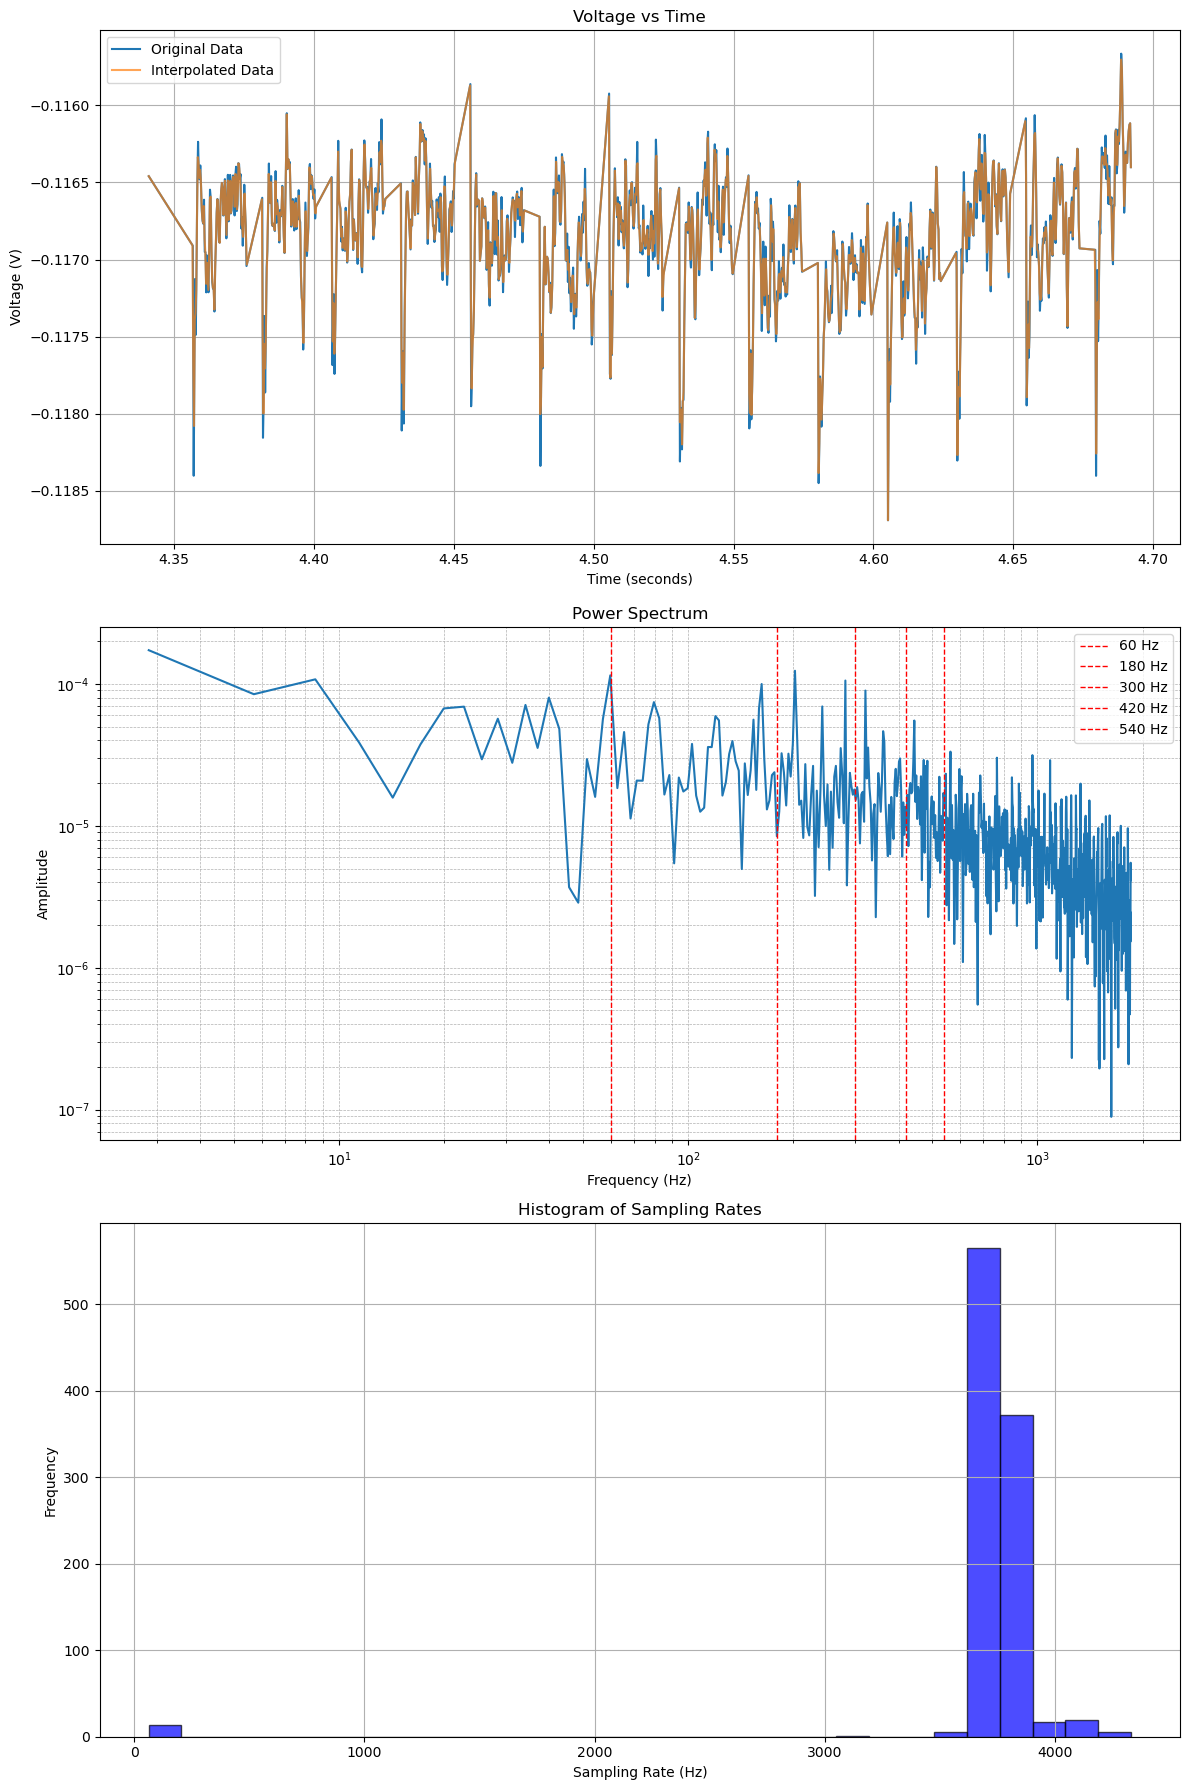

PPS Flag occurrences:
sync
0    1000
Name: count, dtype: int64


In [ ]:
import os
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming 'files' is a list of file names and 'sd_card_path' is the directory path
selected_file_index = 4  # User selects a file index (adjust as needed)
selected_file = files[selected_file_index - 1]

# Construct the full path to the file
file_path = os.path.join(sd_card_path, selected_file)

# Define the struct format used in data packing
sample_format = '<3sI'  # Corresponds to raw_data (3 bytes), combined_time (4 bytes)
sample_size = struct.calcsize(sample_format)  # Should be 7 bytes per sample

# Initialize lists to store unpacked data
V_int_list = []
t_us_list = []
pps_flag_list = []

# Read and unpack the binary data from the file
with open(file_path, 'rb') as f:
    file_content = f.read()

num_samples = len(file_content) // sample_size  # Total number of samples

# Check if there's any incomplete sample at the end
if len(file_content) % sample_size != 0:
    print("Warning: Incomplete sample data at the end of the file will be ignored.")

# Iterate over each sample in the binary data
for i in range(num_samples):
    offset = i * sample_size
    sample_bytes = file_content[offset:offset + sample_size]
    if len(sample_bytes) < sample_size:
        print(f"Skipped incomplete sample at offset {offset}")
        continue
    try:
        # Unpack the binary data
        raw_data, combined_time = struct.unpack(sample_format, sample_bytes)
        
        # Convert raw_data (3 bytes) to a 24-bit signed integer
        raw_int = int.from_bytes(raw_data, byteorder='big', signed=True)
        
        # Extract PPS flag and sample_time from combined_time
        pps_flag = (combined_time >> 31) & 0x1            # Extract the MSB as PPS flag
        sample_time = combined_time & 0x7FFFFFFF          # Extract lower 31 bits as sample_time
        
        # Append to lists
        V_int_list.append(raw_int)
        t_us_list.append(sample_time)
        pps_flag_list.append(pps_flag)
    except struct.error as e:
        print(f"Error unpacking sample at index {i}: {e}")
        continue

# Create a DataFrame with the unpacked data
data = pd.DataFrame({
    'V_int': V_int_list,
    't_us': t_us_list,
    'sync': pps_flag_list
})

# Convert counts to voltage
# Replace 'vmax' with your ADC's reference voltage (e.g., 2.5V)
data['V'] = (data['V_int'] / (2**23 - 1)) * vmax

# Convert time from microseconds to seconds
data['t'] = data['t_us'] * 1e-6

# Print the DataFrame to verify the data
print(data.head())

# Calculate the sampling intervals (differences in time)
t = data['t'].values
V = data['V'].values
dt = np.diff(t)
sampling_rates = 1 / dt
print('Average sample rate:', np.mean(sampling_rates), 'Hz')

# Interpolate data for uniform sampling
nt = int((t[-1] - t[0]) * np.mean(sampling_rates))
interp_t = np.linspace(t[0], t[-1], nt)
interp_func = interp1d(t, V, kind='linear')
interp_V = interp_func(interp_t)

# Calculate FFT
fft_values = np.fft.rfft(interp_V)
amplitudes = (2 * np.abs(fft_values)) / len(interp_V)
freqs = np.fft.rfftfreq(len(interp_t), d=(interp_t[1] - interp_t[0]))

dt_interp = np.diff(interp_t)
sampling_rates_interp = 1 / dt_interp
print('Interpolated sample rate:', np.mean(sampling_rates_interp), 'Hz')

# Create subplots (add an extra subplot for the histogram)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Voltage vs Time Plot
axs[0].plot(t, V, label='Original Data')
axs[0].plot(interp_t, interp_V, label='Interpolated Data', alpha=0.7)
axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Voltage (V)")
axs[0].grid(True)
axs[0].set_title("Voltage vs Time")
axs[0].legend()

# Power Spectrum Plot
axs[1].plot(freqs[1:], amplitudes[1:])
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Amplitude")
axs[1].axvline(60, color='red', linestyle='--', linewidth=1, label="60 Hz")
axs[1].axvline(180, color='red', linestyle='--', linewidth=1, label="180 Hz")
axs[1].axvline(300, color='red', linestyle='--', linewidth=1, label="300 Hz")
axs[1].axvline(420, color='red', linestyle='--', linewidth=1, label="420 Hz")
axs[1].axvline(540, color='red', linestyle='--', linewidth=1, label="540 Hz")
axs[1].grid(True, which="both", linestyle="--", linewidth=0.5)
axs[1].set_title("Power Spectrum")
axs[1].legend()

# Sampling Rate Histogram
axs[2].hist(sampling_rates, bins=30, color='blue', edgecolor='black', alpha=0.7)
axs[2].set_xlabel("Sampling Rate (Hz)")
axs[2].set_ylabel("Frequency")
axs[2].grid(True)
axs[2].set_title("Histogram of Sampling Rates")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Optionally, you can inspect the 'sync' column to see where the PPS signal was detected
print("PPS Flag occurrences:")
print(data['sync'].value_counts())


# Magnetic Field Predictions

biots approximation B field due to multiple wires

In [ ]:
# Constants
mu_0 = 4 * np.pi * 1e-7  # Permeability of free space (T·m/A)
frequency = 60  # Frequency of the AC current in Hz

def calculate_magnetic_field_time_series(x_wires, z_wires, currents, phases, measurement_location, times):
    x_meas, y_meas = measurement_location  # Measurement location
    Bx_total = np.zeros(len(times))  # Total Bx over time
    Bz_total = np.zeros(len(times))  # Total By over time
    B_total = np.zeros(len(times))  # Total magnetic field
    I = np.zeros((len(x_wires), len(times)))  # current
    
    # Calculate magnetic field magnitude and components at each time step
    for it, t in enumerate(times):
        for i, (x, z, current, phi) in enumerate(zip(x_wires, z_wires, currents, phases)):
            # Calculate the instantaneous current as a sinusoidal function
            I_t = current * np.cos(2 * np.pi * frequency * t + phi)
            I[i, it] = I_t
            
            # Distance components from wire to measurement location
            dx = x_meas - x
            dz = y_meas - z
            distance = np.sqrt(dx**2 + dz**2)  # Distance from wire to measurement point

            # Magnetic field due to a long, straight current-carrying wire (Biot-Savart law approximation)
            if distance > 0:
                # Calculate instantaneous magnetic field contribution due to each wire
                Bi = (mu_0 * I_t) / (2 * np.pi * distance)
                
                # Decompose the magnetic field into x and y components
                Bxi = -Bi * (dz / distance)
                Bzi = Bi * (dx / distance)
                
                # Accumulate total magnetic field components from each wire
                Bx_total[it] += Bxi
                Bz_total[it] += Bzi
                B_total[it] += Bi
    
    return B_total, Bx_total, Bz_total, I

# Example parameters
x_wires = [-2, 0, 2, 0]  # x-coordinates of three-phase wires and neutral wire
z_wires = [10, 10, 10, 10]  # z-coordinates of three-phase wires and neutral wire
currents = [200, 200, 200, 0]  # Peak currents in each wire (A)
phases = [2 * np.pi / 3, 0, -2 * np.pi / 3, 0] # Phase angles for each current (radians)
measurement_location = (0, 0)  # Measurement location (x, y)
time_period = 1 / frequency  # Period of the AC current

# Create a time array for one full cycle (0 to time_period)
times = np.linspace(0, time_period, 1000)

# Calculate the magnetic fields and currents
B_total, Bx_total, Bz_total, I = calculate_magnetic_field_time_series(
    x_wires, z_wires, currents, phases, measurement_location, times
)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, label in enumerate(['Phase A', 'Phase B', 'Phase C', 'Neutral']):
    axs[0].plot(times * 1e3, I[i], label=label)  # Convert time to ms
axs[0].set_title("Currents in Each Wire")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Current (A)")
axs[0].legend()
axs[0].grid(True)

# Plot magnetic field strenght (signed)
axs[1].plot(times * 1e3, B_total * 1e9, color='black')  # Convert time to ms and field to nT
axs[1].set_title("Magnetic Field Magnitude at Location")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Magnetic Field Strength (nT)")
axs[1].grid(True)

# Quiver plot for the magnetic field direction at the peak magnitude
max_index = np.argmax(np.abs(B_total))  # Find the index of max |B_magnitude|
Bx_max = Bx_total[max_index]
Bz_max = Bz_total[max_index]
Bx_max_unit = Bx_max / np.sqrt(Bx_max**2 + Bx_max**2)
Bz_max_unit = Bz_max / np.sqrt(Bx_max**2 + Bz_max**2)
axs[2].quiver(measurement_location[0], measurement_location[1], Bx_max_unit, Bz_max_unit, angles='xy', scale_units='xy', scale=1, color='black')
axs[2].scatter(x_wires, z_wires, color='blue', label='Wires')
axs[2].scatter(*measurement_location, color='red', label='Measurement Location')
axs[2].set_title("Layout and Magnetic Field Direction at Max Magnitude")
axs[2].set_xlabel("x (m)")
axs[2].set_ylabel("z (m)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

print("Bx_max:", Bx_max, "Bz_max:", Bz_max)

: 

: 

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
noise_density = 1.5  #  nT/√Hz (from datasheet)
default_bandwidth = 47e3  # Default bandwidth in Hz

frequencies = np.logspace(1, np.log10(default_bandwidth), 500)  # 1 Hz to default bandwidth
noise_spectrum = noise_density * np.sqrt(frequencies) 

# Plot noise levels
plt.figure(figsize=(10, 6))
plt.plot(frequencies,noise_spectrum)
plt.xscale("log")
plt.title("Magnetic Field Noise DRV425")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noise Level (nT)")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()


: 

: 

: 

# Filter design

The transfer function $ H(f) $ for an RC low-pass filter:

$
H(f) = \frac{V_{\text{out}}(f)}{V_{\text{in}}(f)} = \frac{1}{1 + j \frac{f}{f_c}}
$


$
H(f) = \frac{1}{1 + j 2 \pi f R C}
$

$
|H(f)| = \frac{1}{\sqrt{1 + (2 \pi f R C)^2}}
$

the cutoff frequency:

$ f_c = \frac{1}{2 \pi R C}$

Cutoff frequency (fc) for R = 1000.0 ohms and C = 1.50e+05 pF is 1061.03 Hz


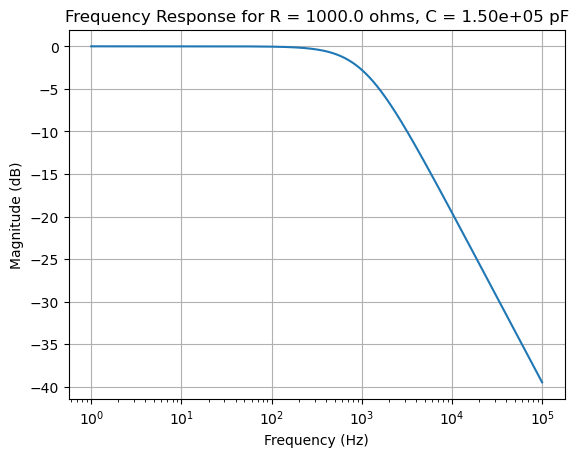

Resistance (R) for fc = 900 Hz and C = 1.50e+05 pF is 1178.93 ohms


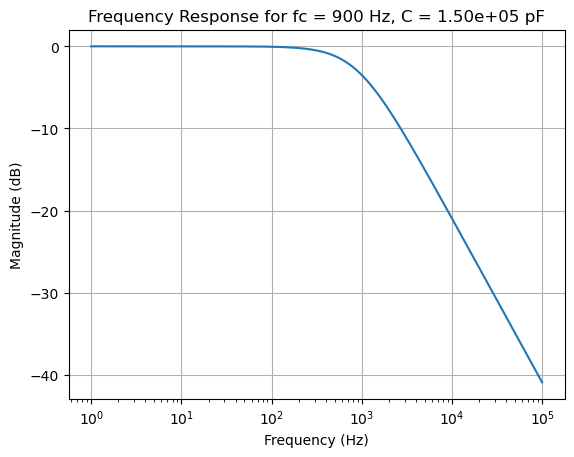

Capacitance (C) for fc = 900 Hz and R = 10000.0 ohms is 1.77e+04 pF


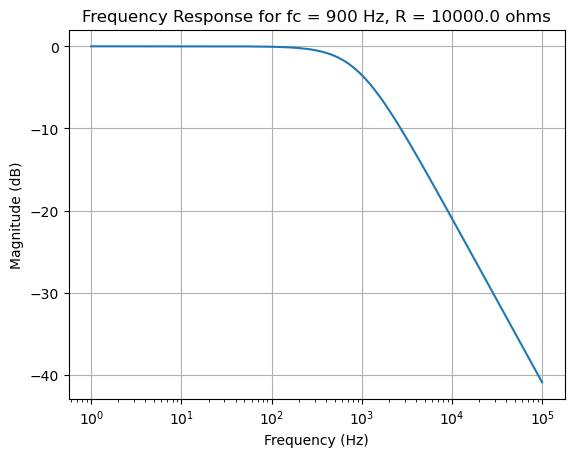

: 

: 

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_cutoff_frequency(R, C_pF):
    """Calculate the cutoff frequency given R and C in pF."""
    C = C_pF * 1e-12  # Convert pF to F
    fc = 1 / (2 * np.pi * R * C)
    return fc

def calculate_resistance(fc, C_pF):
    """Calculate the resistance R given fc and C in pF."""
    C = C_pF * 1e-12  # Convert pF to F
    R = 1 / (2 * np.pi * fc * C)
    return R

def calculate_capacitance(fc, R):
    """Calculate the capacitance C in pF given fc and R."""
    C = 1 / (2 * np.pi * fc * R)  # Result in Farads
    C_pF = C * 1e12  # Convert F to pF
    return C_pF

def plot_frequency_response(R, C_pF, title):
    """Plot the frequency response for a given R and C in pF."""
    C = C_pF * 1e-12  # Convert pF to F
    frequencies = np.logspace(0, 5, 500)  # Frequency range from 1 Hz to 100 kHz
    response = 1 / np.sqrt(1 + (2 * np.pi * frequencies * R * C) ** 2)
    plt.figure()
    plt.semilogx(frequencies, 20 * np.log10(response))  # Plot in dB
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.show()

# Example 1: Calculate cutoff frequency
R = 1e3  # Ohms
C_pF = 15e4  # Capacitance in pF
fc = calculate_cutoff_frequency(R, C_pF)
print(f"Cutoff frequency (fc) for R = {R} ohms and C = {C_pF:.2e} pF is {fc:.2f} Hz")
plot_frequency_response(R, C_pF, f"Frequency Response for R = {R} ohms, C = {C_pF:.2e} pF")

# Example 2: Calculate resistance
fc = 180 * 5  # Hz
C_pF = 15e4  # Capacitance in pF
R = calculate_resistance(fc, C_pF)
print(f"Resistance (R) for fc = {fc} Hz and C = {C_pF:.2e} pF is {R:.2f} ohms")
plot_frequency_response(R, C_pF, f"Frequency Response for fc = {fc} Hz, C = {C_pF:.2e} pF")

# Example 3: Calculate capacitance
fc = 180 * 5  # Hz    
R = 10e3  # Ohms
C_pF = calculate_capacitance(fc, R)
print(f"Capacitance (C) for fc = {fc} Hz and R = {R} ohms is {C_pF:.2e} pF")
plot_frequency_response(R, C_pF, f"Frequency Response for fc = {fc} Hz, R = {R} ohms")


In [10]:
#single butterworth

k1 = 0.1592
k2 = 0.586

fc = 660 # Hz  
C = 10e-6
print(C)

R = k1/(C*fc)
print(R)

R1 = 1e3
Rf = R1 * k2
print(Rf)

1e-05
24.12121212121212
586.0


In [ ]:
# dobule butterworth

k1 = 0.1592
k21 = 0.152
k22 = 1.235

fc = 660 # Hz  
C = 10e4 * 1e-12
print(C)

R = k1/(C*fc)
print(R)

R1 = 10e3
Rf1 = R1 * k21
print(Rf1)

Rf2 = R1 * k22
print(Rf2)

1e-07
2412.1212121212125
1520.0
12350.000000000002
